# Modele de réseau neuronale

19/4/21 11:20
Un nouveau modele est pret à être train

## Imports

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
#import seaborn as sns #On ne sait jamais que ça serve
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler #Normalisation #Il faut l'installer aussi avec conda install
import random
from math import ceil
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import  Dense, Conv3D, BatchNormalization,MaxPooling3D, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard


#conda install pydot
#conda install pydotplus
#conda install graphviz
from tensorflow.keras.utils import plot_model
#import pydot


import threading
from queue import Queue, Empty
from time import sleep, time

### Paramètres généraux

In [2]:
fps = 10
size = (100,75) #(40,30)
nb_classes = 10 #Nombre de classes
epochs = 2 #20
batch_size = 25
pack_size = 50
learning_rate = 0.001
modele_n = 10

In [3]:
#Verification qu'un modele avec ces paramètres n'existe pas déjà
folder = 'Saved_model'
modele_type = 'model_convLSTM2D'
param = f"_{modele_n}_{fps}_{size[1]}_{size[0]}_{nb_classes}_{epochs}_{batch_size}_{pack_size}_{int(learning_rate*1000)}mili"
full_name = folder + '\\' + modele_type + param
print(full_name)

Saved_model\model_convLSTM2D_10_10_75_100_10_2_25_50_1mili


## Fonctions d'imports et preprocess

#### Import

In [4]:
def get_mov_imgs_from_path(path,fps = -1,color = 'gray'):
    '''
    Retourne une liste d'images pour une vidéo. La liste d'image a le nombre de fps voulu
    reprend que le mouvement
    '''
    
    cap = cv2.VideoCapture(path)
    try:
        fps_actu = cap.get(cv2.CAP_PROP_FPS)
    #     print(f"Traitement de la video n° {path}       ",end="\r")
        if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
        ecart_voulu = int(1000/fps)
        ecart_initial = int(1000/fps_actu)
        imgs = []

        ret, frame = cap.read()
        while(cap.isOpened()):
            prev = frame
            ret, frame = cap.read()



            if ret: #Sinon ça plante quand il n'y a plus d'images
                #Récupère seulement certaines images
                t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
                modulo = t_ms % ecart_voulu
                if modulo < ecart_initial:
                    #Isoler les images

                    if color == 'gray':
                        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                        prev_gray = cv2.cvtColor(prev,cv2.COLOR_BGR2GRAY)
                        diff_gray = cv2.absdiff(gray,prev_gray)

                    elif color == 'rgb':
                        diff_gray = cv2.absdiff(frame,prev) 


                    #Première normalisation (elle n'est peut-être pas obligatoire)
                    max_ = np.max(diff_gray)
                    if max_ == 0:
                        max_ = 1
                    ratio = 255.0 / max_
                    diff_gray = diff_gray * ratio


                    #On va travailler avec des images en nuance de gris, c'est bcp plus simple
                    imgs.append(diff_gray)

            else: #Va jusqu'au bout de la vidéo
                break
        else:
            print("Le fichier n'a pas pu être ouvert")
    except:
        print(f"IL Y A UN PROBLEME AVEC LA VIDEO: {path}")
        return None
    cap.release()
    
    return imgs

#### Resize

In [5]:
def resize_imgs(imgs,nsize):
    '''
    Change la taille de l'image.
    Le premier élément de nsize est la longueur (width), le deuxième la hauteur (height)
    '''
    return [cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC) for img in imgs]

#### Normalisation

In [6]:
def normalize_imgs(imgs):
    '''
    Normalise une série d'images
    '''
    return [cv2.normalize(img,0,1,cv2.NORM_MINMAX) for img in imgs]

## Fonction de générateur

In [50]:
def my_gen(labels_list, folder_path, pack_size = 10, pointer = 0, fps = 5, size = (160,120)):
    '''
    à partir de la liste des labels et de la position du foler
    Retourne:
    -une liste d'images de vidéos de shape (pack_size,n_frames,height,width[,channels])
        n_frames = fps*2.4
    -Une liste de numérique avec les labels correspondant aux images (de len = batch_size)
    -Un pointer qui permet de faire tourner my_gen à nouveau et recevoir les éléments suivants de la liste
    
    
    Normalement on peut envoyer X et y_num dans le modele directement (avec fit ou train_on_batch, les deux devraient fonctionner)
    Je vais essayer de travailler avec des thread pour avoir un thread en Train et un trhead en gen
    '''
    #Affiche combien de paquets il faudra
    random.shuffle(labels_list)
    len_label = len(labels_list)
    if pointer == 0:
        #Uniquement le premier passage
        nb_pack = ceil(len_label/pack_size)
        print(f"Il y aura {nb_pack} packs de {min(pack_size,len_label)} vidéos à importer")
    else:
        print(f"Il reste encore {len_label - pointer} vidéos à importer")
    
    y_num = []
    X = []
    for i in range(pointer, pack_size + pointer):
        pointer = i+1
        if i >= len_label:
            break
        label, video_name = labels_list[i]
        
        #Label en numérique
        y_num.append(labels_n[label])
        
        #Preprocess d'images
        file_path = folder_path + "\\" + video_name
        imgs_of_video = get_mov_imgs_from_path(file_path,fps,'gray') #Gray ou rgb
        if imgs_of_video == None:
            continue
        resized_imgs = resize_imgs(imgs_of_video, size)
        norm_imgs = normalize_imgs(resized_imgs)
        
        X.append(norm_imgs)
        
    print() #Pour ne pas écrire sur la même ligne qu'avant
    X = np.array(X)
    y = np.array(y_num)
    
    #Ajouter une dimsension en à la fin est nécessaire pour certains modèle
    #Commenter cette ligne si ce n'est pas nécessaire
    X = np.expand_dims(X, axis=len(X.shape)) 
    
    # Si le modele est compile avec :loss='sparse_categorical_crossentropy'
    # Il faut un y catégorique , faire ça hors de la fonction
    #y = to_categorical(y, num_classes = nb_classes)

    return (X, y, pointer)

In [51]:
def import_for_test(path, fps = 10, size = (100,75)):
    X = []
    file_paths = os.listdir(path)
    for file in file_paths:
        imgs_of_video = get_mov_imgs_from_path(path+"\\"+file,fps,'gray') #Gray ou rgb
        if imgs_of_video == None:
            print("Il y a un problème avec la video: ",path)
            continue
        resized_imgs = resize_imgs(imgs_of_video, size)
        norm_imgs = normalize_imgs(resized_imgs)
        
        X.append(norm_imgs)
    X = np.array(X)
    
    #Ajouter une dimsension en à la fin est nécessaire pour certains modèle
    #Commenter cette ligne si ce n'est pas nécessaire
    X = np.expand_dims(X, axis=len(X.shape)) 

    return X

## Import des données et traitement

In [61]:
#Import des labels
labels_csv = pd.read_csv("DATA\\labels.csv")
labels_name = pd.read_csv("DATA\\labels_uses.csv")
labels_tests_csv = pd.read_csv("DATA\\labels_tests.csv")

In [62]:
#Créé un dictionnaire qui associe le nom du label et un numérique afin de le mettre dans le modele
labels_n = {}
for i,label in enumerate(labels_name.values):
    labels_n[label[0]] = i
    labels_n[i] = label[0]

    
#Trier les labels pour ne prendre que ceux qui correspondent à labels_uses
labels = []
for label, video_name in labels_csv.values:
    if label in labels_n:
        labels.append((label,video_name))

#Idem pour le label de tests
labels_tests = []
for label, video_name in labels_tests_csv.values:
    if label in labels_n:
        labels_tests.append((label,video_name))


#Melange la liste de train
for j in range(5):
    random.shuffle(labels) #Il faut absolument shuffle pour train

In [59]:
#Import du modele
model_h5 = keras.models.load_model("Saved_model\\model_convLSTM2D_8_10_75_100_10_2_50_50_1mili.h5")
model = keras.models.load_model("Saved_model\\model_convLSTM2D_8_10_75_100_10_2_50_50_1mili")

## Tests

In [55]:
X = import_for_test("DATA\\temp_video",fps = fps, size = size)
X_test, y_test, _ = my_gen(labels_tests, "DATA\\V_tests",pack_size = 20,fps = fps, size = size)
#Grand pack_size afin de prendre toutes les données

Il y aura 7 packs de 20 vidéos à importer



In [56]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 997us/step


In [63]:
X_train, y_train, _ = my_gen(labels,"DATA\\Videos",pack_size = 20,fps = fps, size = size)

Il y aura 72 packs de 20 vidéos à importer



In [65]:
y_train_pred = model.predict(X_train)

C:\Users\william\Documents\Scolaire\M1\Systèmes_Intelligents\Hand_Gesture_Recognition\fidle\pwk.py:520: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


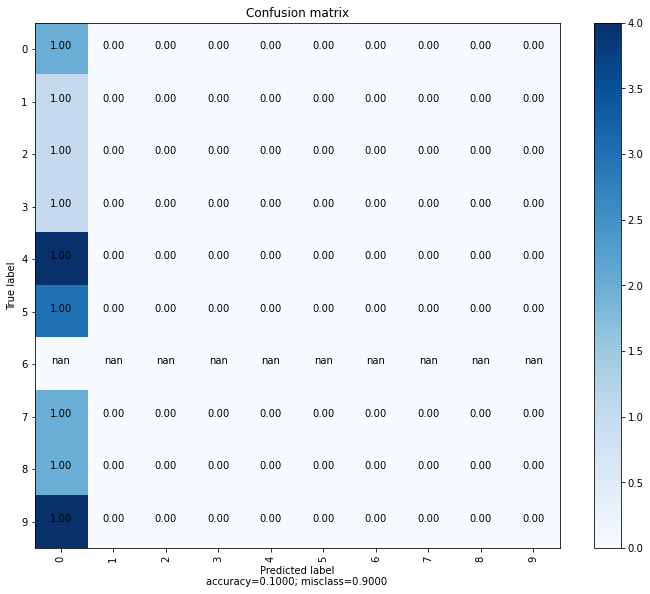

In [66]:
y_pred_train_arg = np.argmax(y_pred, axis=-1)
cfm_plot = pwk.plot_confusion_matrix(y_train,y_pred_train_arg,range(nb_classes),normalize=True)

In [68]:
y_pred_train_arg

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [67]:
y_train

array([9, 2, 9, 9, 1, 3, 4, 8, 7, 7, 5, 0, 4, 9, 5, 8, 5, 0, 4, 4])

## Affichage d'une video avec la prédiction pour comprendre si le résultat est justifié ou non

In [ ]:
plt.figure(figsize=(20,60)) #(20,60) pour des images en (120,160). (20,180) pour des images en (480,640)
#print(X_test.shape)
#Visu des mouvements avec une petite size (en fonction des paramètres initiaux)
columns = 3
vid_a_test = 11
print("prediction:",labels_n[y_pred[vid_a_test].argmax()])
for i, img in enumerate(X[vid_a_test]):
    plt.subplot(int(len(img) / columns + 1), columns, i + 1)
    plt.imshow(img)

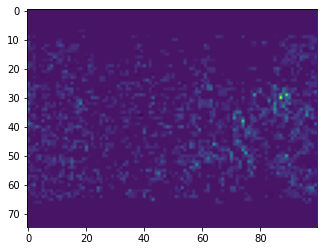

### visualisation des  résultats

In [37]:
import fidle.pwk as pwk

In [38]:
full_name

'Saved_model\\model_convLSTM2D_10_10_75_100_10_2_25_50_1mili'

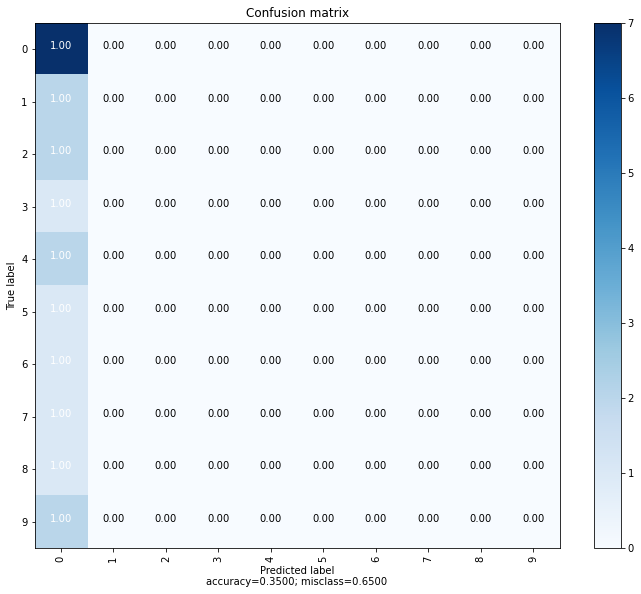

In [41]:
y_pred_arg = np.argmax(y_pred, axis=-1)
cfm_plot = pwk.plot_confusion_matrix(y_test,y_pred_arg,range(nb_classes),normalize=True)

In [42]:
y_test_cat = to_categorical(y_test,10)
score = model.evaluate(X_test, y_test_cat, verbose=1)

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

1/1 [==============================] - 0s 1ms/step - loss: 3.0753 - accuracy: 0.3500
Test loss     : 3.075277328491211
Test accuracy : 0.3499999940395355


In [ ]:
#y_pred

In [43]:
#On vérifie que les résultats sont normalisé
for result in y_pred:
    print('la somme est:',sum(result))
    pass

la somme est: 1.0000000654254109
la somme est: 1.0000000193249434
la somme est: 0.9999999750871211
la somme est: 0.9999999941792339
la somme est: 1.0000000155996531
la somme est: 1.000000020954758
la somme est: 1.0000001355074346
la somme est: 1.0000000651925802
la somme est: 0.9999999501742423
la somme est: 0.99999999278225
la somme est: 1.0000001098960638
la somme est: 0.9999999129213393
la somme est: 0.999999929452315
la somme est: 1.000000027474016
la somme est: 1.0000001557637006
la somme est: 0.999999959487468
la somme est: 1.0000001024454832
la somme est: 0.9999999932479113
la somme est: 0.9999998754356056
la somme est: 1.0000000521540642


In [ ]:
print(labels_n)

In [ ]:
#Je peux afficher l'historique de chaque étape (je n'ai aps réussi à les faire fusionner)
#On ne peut afficher que si on a train

#history = histories[-1]
#pwk.plot_history(history, figsize=(6,4), save_as='03-history')

## Enregistrer le modèle

In [ ]:
#Le nom est fabriqué en début de notebook

In [ ]:
#Enregistrement du résultat dans le csv

In [43]:
def write_score(model_name,score):
    labels = open("Saved_model\\score.csv","a") #append
    labels.write("\n" + model_name + "," + "{:10.8f}".format(score[0]) + "," + "{:10.8f}".format(score[1]))
    #Ajoute une nouvelle info sur une nouvelle ligne
    labels.close()

In [14]:
print(full_name)

Saved_model\model_convLSTM2D_10_10_75_100_10_2_25_50_1mili


In [13]:
#write_score(full_name,score)
#model.save(full_name+".h5")

NameError: name 'model_charge' is not defined

In [42]:
#Compte le nombre de bons et de mauvais qu'on a ainsi que la moyenne,
curseur  = 0.0 #curseur de 0 pour avoir tous les résultats
count_good = 0
to_mean_good = 0
count_bad = 0
to_mean_bad = 0
for i,pred in enumerate(y_pred):
    #Curseur
    if np.max(pred) < curseur:
        continue
    if np.argmax(pred) == y_test[i]:
        count_good += 1
        to_mean_good += max(pred)
    else:
        count_bad +=1
        to_mean_bad += max(pred)
if count_good != 0:
    mean_good = to_mean_good/count_good
else: mean_good = 0
if count_bad != 0:
    mean_bad = to_mean_bad /count_bad
else: mean_bad = 0
print("Nombre de bon :", count_good," Moyenne :",mean_good)
print("Nombre de mauvais :",count_bad, " Moyenne :",mean_bad)
#On constate que le modèle est souvent très sûr de ce qu'il avance

Nombre de bon : 13  Moyenne : 0.5191479944265806
Nombre de mauvais : 117  Moyenne : 0.5220455830423241


array([0.53338206, 0.2881288 , 0.02981834, 0.01517537, 0.01135925,
       0.01279822, 0.00411733, 0.00403606, 0.01515242, 0.08603222],
      dtype=float32)

In [ ]:
with tf.device('cpu:0'):
    y_pred = model_saved_test.predict(X_test)

In [ ]:
y_pred_arg = np.argmax(y_pred, axis=-1)
plot_confusion_name = full_name + 'test_saved_model'+ '_confusion.png'
cfm_plot = pwk.plot_confusion_matrix(y_test,y_pred_arg,range(nb_classes),normalize=True)